<h1><b>Notebook for Coursera Capstone Project</b></h1>

<h3>Importing Required Packages/Libraries</h3>

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  46.96 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.11 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.69 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.19 MB/s
Libraries imported.


<h3>Setting the Client ID and Secret for FourSquare API</h3>

In [2]:
CLIENT_ID = 'BXUCQL0SNFYNWJMRCBIKFNRDWDXRWZZIRRMYJNI1XLX30GGJ' # your Foursquare ID
CLIENT_SECRET = 'CTP1DLYFU0O4ZTMOKP5OYOSWOGUB3TKRRBQKSPAWQGCXB4XI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BXUCQL0SNFYNWJMRCBIKFNRDWDXRWZZIRRMYJNI1XLX30GGJ
CLIENT_SECRET:CTP1DLYFU0O4ZTMOKP5OYOSWOGUB3TKRRBQKSPAWQGCXB4XI


<h3> Download New York location data using dataset https://cocl.us/new_york_dataset </h3>

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


<h3>Load Data</h3>

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

<h3>All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, defined a new variable that includes this data.</h3>

In [5]:
neighborhoods_data = newyork_data['features']

<h3> Tranform the data into a *pandas* dataframe </h3>

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

<h3>Loop through the data and fill the dataframe one row at a time.</h3>

In [7]:
for data in neighborhoods_data:
    borough  = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

<h3> Filter only Manhattan Borough. Same results can be replicated thorughout New York </h3>

In [8]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

<h3> Visualize Manhattan Neighborhoods </h3>

In [9]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [10]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

<h3>Function to explore venues of each neighborhood in Manhattan </h3>

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [103]:
# Call fuction to explore Neighborhoods
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

In [104]:
manhattan_restaurants=manhattan_venues[manhattan_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
manhattan_restaurants.shape

(932, 8)

<h3>Drop columns with respect to neighborhood as we are going to cluster similar venues </h3>

In [105]:
manhattan_restaurants = manhattan_restaurants.drop(['Neighborhood', 'Neighborhood Latitude','Neighborhood Longitude'], axis=1)


<h3>Function to get number of likes a Restaurant received of each neighborhood in Manhattan </h3>

In [77]:
def VenueDetails(Venue_ID):

    venues_list=[]
        # create the API request URL
    for Venue_ID in Venue_ID:
        
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
                Venue_ID,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                )

            # make the GET request
        results = requests.get(url).json()["response"]
       

            # return only relevant information for each nearby venue
        venues_list.append([(
                results['likes']['count']
               )])
      
    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = [
                      'Likes' 
                      ]
    
    return(nearby_venues)


In [111]:
manhattan_venues_details = VenueDetails(Venue_ID=manhattan_restaurants['Venue ID'])

In [112]:
manhattan_venues_details.head()

,Likes
0,42
1,4
2,473
3,761
4,702


In [113]:
manhattan_restaurants['Likes']=manhattan_venues_details['Likes']

In [114]:
manhattan_restaurants.head()

,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
0,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,42
1,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,American Restaurant,4
2,4db3374590a0843f295fb69b,Spicy Village,40.717010,-73.993530,Chinese Restaurant,473
3,5521c2ff498ebe2368634187,Kiki's,40.714476,-73.992036,Greek Restaurant,761
4,4c9d482e46978cfa8247967f,The Fat Radish,40.715323,-73.991950,English Restaurant,702


<h3>Analyze Clusters of Venues</h3>

In [115]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add existing columns back to dataframe
manhattan_onehot['Venue ID'] = manhattan_restaurants['Venue ID'] 
manhattan_onehot['Venue Latitude'] = manhattan_restaurants['Venue Latitude']
manhattan_onehot['Venue Longitude'] = manhattan_restaurants['Venue Longitude']
manhattan_onehot['Likes'] = manhattan_restaurants['Likes']
manhattan_onehot['Venue'] = manhattan_restaurants['Venue']


# move Venue column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Venue,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Venue ID,Venue Latitude,Venue Longitude,Likes
0,Land & Sea Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4b9c9c6af964a520b27236e3,40.877885,-73.905873,42
1,Boston Market,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,585c205665e7c70a2f1055ea,40.877430,-73.905412,4
2,Spicy Village,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4db3374590a0843f295fb69b,40.717010,-73.993530,473
3,Kiki's,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5521c2ff498ebe2368634187,40.714476,-73.992036,761
4,The Fat Radish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4c9d482e46978cfa8247967f,40.715323,-73.991950,702


In [116]:
manhattan_grouped_clustering = manhattan_onehot.drop(['Venue', 'Venue ID','Venue Latitude','Venue Longitude'], axis=1)

<h3> Finding the optimal K value using Elbow Method </h3>

In [117]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(manhattan_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

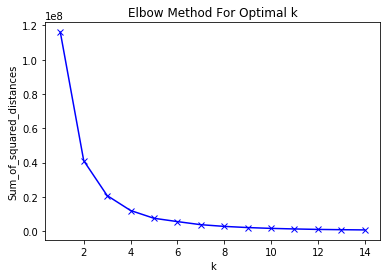

In [118]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<h3> Clustering the Restaurants in Manhattan using K=5 </h3>

In [119]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 2, 2, 0, 2, 0, 2, 0], dtype=int32)

In [120]:
manhattan_restaurants.insert(0, 'Cluster Labels', kmeans.labels_)

In [121]:
manhattan_restaurants.head()

,Cluster Labels,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
0,0,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,42
1,0,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,American Restaurant,4
2,4,4db3374590a0843f295fb69b,Spicy Village,40.717010,-73.993530,Chinese Restaurant,473
3,2,5521c2ff498ebe2368634187,Kiki's,40.714476,-73.992036,Greek Restaurant,761
4,2,4c9d482e46978cfa8247967f,The Fat Radish,40.715323,-73.991950,English Restaurant,702


<h3>Cluster 1 </h3>

In [122]:
cluster0 = manhattan_restaurants[manhattan_restaurants['Cluster Labels'] ==0].reset_index(drop=True)

In [143]:
cluster0.sort_values(by=['Likes'],ascending=False)

,Cluster Labels,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
214,0,4a2ff171f964a520f6981fe3,Nanoosh,40.775823,-73.982204,Mediterranean Restaurant,191
233,0,49d5651df964a520915c1fe3,Nizza,40.760100,-73.991378,Italian Restaurant,189
191,0,4a7a543df964a5202ee91fe3,Flor de Mayo,40.785966,-73.976312,Peruvian Restaurant,189
485,0,4c056685d3842d7fea21be41,"Lips Drag Queen Show Palace, Restaurant & Bar",40.759226,-73.966934,American Restaurant,188
495,0,4b5ae93df964a520e9d928e3,Ethos,40.754526,-73.966048,Greek Restaurant,188
17,0,3fd66200f964a5209fe61ee3,Oriental Garden 福臨門海鮮酒家,40.715891,-73.997336,Dim Sum Restaurant,188
228,0,523509c311d2c78aeef22885,The Marshal,40.761341,-73.994277,New American Restaurant,188
138,0,4be1fe8b660ec9282567c83b,Sojourn,40.773367,-73.955511,Tapas Restaurant,187
555,0,4ad64e3ff964a520700621e3,Sophie's Cuban Cuisine,40.740832,-73.987710,Cuban Restaurant,186
8,0,472a027af964a520ea4b1fe3,Bacaro,40.714468,-73.991589,Italian Restaurant,185


<h3>Cluster 2 </h3>

In [124]:
cluster1 = manhattan_restaurants[manhattan_restaurants['Cluster Labels'] ==1].reset_index(drop=True)

In [144]:
cluster1.sort_values(by=['Likes'],ascending=False)

,Cluster Labels,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
27,1,4f0f47650cd695a0e54cb438,Jack's Wife Freda,40.722022,-73.997528,Mediterranean Restaurant,1676
24,1,4f0f47650cd695a0e54cb438,Jack's Wife Freda,40.722022,-73.997528,Mediterranean Restaurant,1676
38,1,4e73cf3a2271ffa4e63183bd,The Smith,40.755376,-73.968243,American Restaurant,1523
10,1,43850280f964a520fd2a1fe3,Cookshop,40.745731,-74.005596,American Restaurant,1499
4,1,5078c4f1e4b0dad821e1f6bd,The Smith,40.771505,-73.982292,American Restaurant,1483
41,1,3fd66200f964a520aee91ee3,Gramercy Tavern,40.738600,-73.988320,American Restaurant,1468
8,1,44e9b421f964a520a5371fe3,Buddakan,40.742120,-74.004612,Asian Restaurant,1418
13,1,4d9db7087f9e4eb9436ea1fc,The Dutch,40.726542,-74.002252,New American Restaurant,1413
33,1,4afb2990f964a520a91b22e3,Maialino,40.738442,-73.985610,Italian Restaurant,1409
22,1,40f1d480f964a5205b0a1fe3,Bubby's,40.719932,-74.008572,American Restaurant,1396


<h3>Cluster 3 </h3>

In [126]:
cluster2 = manhattan_restaurants[manhattan_restaurants['Cluster Labels'] ==2].reset_index(drop=True)

In [142]:
cluster2.sort_values(by=['Likes'],ascending=False)

,Cluster Labels,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
15,2,517021ffe4b0ad9829ae7815,Xi'an Famous Foods,40.755926,-73.980751,Chinese Restaurant,911
76,2,49becfd3f964a520e0541fe3,Woorijip,40.747623,-73.986372,Korean Restaurant,892
69,2,4e691e82b9930387355c629d,Saxon + Parole,40.725151,-73.992334,American Restaurant,870
87,2,542b39ed498e2f39c3a93fc4,Cosme,40.739500,-73.988440,Mexican Restaurant,865
89,2,44f4b0ebf964a52036381fe3,Boqueria,40.740200,-73.993770,Tapas Restaurant,862
39,2,45697387f964a520e53d1fe3,Despaña,40.721144,-73.997963,Spanish Restaurant,854
46,2,45697387f964a520e53d1fe3,Despaña,40.721144,-73.997963,Spanish Restaurant,854
33,2,4c2a81398abca59393c8fe1f,Xi'an Famous Foods,40.727682,-73.985525,Chinese Restaurant,851
62,2,3fd66200f964a520d0e41ee3,Lil' Frankie's,40.723445,-73.988328,Italian Restaurant,840
29,2,4758483af964a520cc4c1fe3,Westville East,40.728502,-73.981795,American Restaurant,822


<h3>Cluster 4 </h3>

In [128]:
cluster3 = manhattan_restaurants[manhattan_restaurants['Cluster Labels'] ==3].reset_index(drop=True)

In [141]:
cluster3.sort_values(by=['Likes'],ascending=False)

,Cluster Labels,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
3,3,3fd66200f964a52070e91ee3,Balthazar,40.722724,-73.998170,French Restaurant,2931
4,3,3fd66200f964a52070e91ee3,Balthazar,40.722724,-73.998170,French Restaurant,2931
1,3,4731be8af964a520244c1fe3,Momofuku Noodle Bar,40.729133,-73.984265,Ramen Restaurant,2335
8,3,4b998a8ff964a520098235e3,ABC Kitchen,40.737653,-73.989658,New American Restaurant,2239
7,3,4169cd00f964a5208c1d1fe3,Freemans,40.721837,-73.992451,American Restaurant,2052
2,3,431e2d80f964a52079271fe3,La Esquina,40.721598,-73.997471,Mexican Restaurant,1908
5,3,431e2d80f964a52079271fe3,La Esquina,40.721598,-73.997471,Mexican Restaurant,1908
0,3,4edfd5865c5cced979ab7dd1,Jacob's Pickles,40.786653,-73.975622,Southern / Soul Food Restaurant,1868
6,3,4d0bf7e3f29c236ac675bfe7,Buvette,40.732782,-74.004275,French Restaurant,1745


<h3>Cluster 5 </h3>

In [130]:
cluster4 = manhattan_restaurants[manhattan_restaurants['Cluster Labels'] ==4].reset_index(drop=True)

In [145]:
cluster4.sort_values(by=['Likes'],ascending=False)

,Cluster Labels,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
166,4,53b8c811498ee296db5cfaed,Dirty French,40.721837,-73.987360,French Restaurant,482
0,4,4db3374590a0843f295fb69b,Spicy Village,40.717010,-73.993530,Chinese Restaurant,473
200,4,48208c8cf964a520894f1fe3,Gyu-Kaku Japanese BBQ,40.755731,-73.970897,Japanese Restaurant,461
88,4,4593ed04f964a52050401fe3,The Kati Roll Company,40.729570,-74.000861,Indian Restaurant,459
97,4,549c6881498eaaf3954382f3,Superiority Burger,40.727549,-73.983290,Vegetarian / Vegan Restaurant,457
114,4,4e4190fafa762ad6d846f883,Sarabeth's,40.718152,-74.010480,American Restaurant,453
124,4,51033bf5e4b0f8687e44c0e7,The Boil,40.719726,-73.993054,Seafood Restaurant,453
176,4,545c0436498e798e22ce4b2a,Little Park,40.715487,-74.009133,American Restaurant,449
4,4,530ff20411d2a01b7bb8a19c,99 Favor Taste 99號餐廳,40.717756,-73.992515,Hotpot Restaurant,447
171,4,56184ed9498e2ebb67472504,Raku,40.726596,-73.986649,Udon Restaurant,446


<h3> Get list of venues tipped by user(Sample User ID taken '484542633' ) </h3>

In [56]:
user_id = '484542633' # user ID with most agree counts and complete profile

url = 'https://api.foursquare.com/v2/users/{}/tips?client_id={}&client_secret={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION) # define URL

# send GET request
results = requests.get(url).json()
user_data_tips = results['response']['tips']['items']

# display features associated with user

user_data = json_normalize(user_data_tips)

# filter columns
filtered_columns = ['venue.name','authorInteractionType','venue.id','venue.location.lat','venue.location.lng']
user_data_filtered = user_data.loc[:, filtered_columns]

# display user's tips


df=pd.get_dummies(user_data_filtered[['authorInteractionType']], prefix="", prefix_sep="")
user_data_filtered['Liked']=df['liked']


In [58]:
def UserVenueDetails(Venue_ID):

    venues_list=[]
        # create the API request URL
    for Venue_ID in Venue_ID:
        
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                Venue_ID,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                )

            # make the GET request
        results = requests.get(url).json()["response"]
       

            # return only relevant information for each nearby venue
        venues_list.append([(
                results['venue']['id'],
                results['venue']['name'], 
                results['venue']['location']['lat'], 
                results['venue']['location']['lng'],
                results['venue']['categories'][0]['name'],
                results['venue']['likes']['count']
               )])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Venue ID',
                    'Venue', 
                    'Venue Latitude', 
                    'Venue Longitude',
                    'Venue Category',
                    'Likes' 
                      ]
  
    return(nearby_venues)


In [110]:
user_venues_details = UserVenueDetails(Venue_ID=user_liked_venue['venue.id'])


In [137]:
user_venues_details=user_venues_details[user_venues_details['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
user_venues_details.head()

,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
0,49bf289bf964a5200a551fe3,Cafe Cluny,40.737538,-74.003897,American Restaurant,755
1,4f3046da7beb0cfa14dcac59,Taïm Falafel and Smoothie Bar,40.721936,-73.996279,Falafel Restaurant,950
2,4afe06a9f964a520302d22e3,Porto-Bello Restaurant,40.728757,-73.999400,Italian Restaurant,21
3,56dcacb9498e12e3c47eb759,The Warren NYC,40.733176,-74.006752,Restaurant,47
4,3fd66200f964a520e9e61ee3,Cowgirl,40.733733,-74.006300,Southern / Soul Food Restaurant,347


In [138]:
result=user_venues_details.groupby('Venue Category').count()

In [139]:
top_category_visited_by_user = result.sort_values(by=['Venue ID'],ascending=False)

In [140]:
top_category_visited_by_user.head(5)

,Venue ID,Venue,Venue Latitude,Venue Longitude,Likes
Venue Category,,,,,
American Restaurant,2,2,2,2,2
Mexican Restaurant,2,2,2,2,2
Falafel Restaurant,1,1,1,1,1
Israeli Restaurant,1,1,1,1,1
Italian Restaurant,1,1,1,1,1
